In [40]:
%load_ext autoreload
%autoreload 2

In [41]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### IMPUTATION ###

# MissForest imputation
from missforest import MissForest

# GAIN imputation
from hyperimpute.plugins.imputers import Imputers

2024-09-05 12:05:05.562795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 12:05:05.567532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 12:05:05.584941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 12:05:05.610892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 12:05:05.618976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 12:05:05.640645: I tensorflow/core/platform/cpu_feature_gu

In [42]:
%cd Users/yixuan/workshop

/mnt/batch/tasks/shared/LS_root/mounts/clusters/sdg-yixuan-cpu-advanced/code/Users/yixuan/workshop


/anaconda/envs/workshop/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Import custom functions

In [43]:
from utils import (
    cal_ml_efficiency,
    cal_metrics,
    gene_missing_at_random,
    impute_missing_values,
)

### Mixed-type Tabular + Missing Not at Random

https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset

In [45]:
# Load MNAR data
cirrhosis = pd.read_csv("data/tabular/cirrhosis.csv")
categorical_columns = [
    "Status",
    "Drug",
    "Sex",
    "Ascites",
    "Hepatomegaly",
    "Spiders",
    "Edema",
    "Stage",
]

Let's have a first glance of the data.

In [46]:
cirrhosis.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

We would like to check if the data has the issue of class imbalance to decide which evaluation metric is more appropriate for our analysis.

Also, in the context of healthcare data, which metric should we favor more?

In [47]:
cirrhosis.Status.value_counts()

Status
C     232
D     161
CL     25
Name: count, dtype: int64

Also let's check the class imbalance for rows with any missing values.

In [48]:
cirrhosis[cirrhosis.isnull().any(axis=1)].Status.value_counts()

Status
C     85
D     50
CL     7
Name: count, dtype: int64

And the ratio.

In [49]:
cirrhosis[
    cirrhosis.isnull().any(axis=1)
].Status.value_counts() / cirrhosis.Status.value_counts()

Status
C     0.366379
D     0.310559
CL    0.280000
Name: count, dtype: float64

In [66]:
# Ordinal encoding
encoder = ce.OrdinalEncoder(handle_missing="return_nan")
encoded_df = encoder.fit_transform(cirrhosis)

In [67]:
encoded_df

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,1.0,1.0,21464,1.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,2.0,1.0,20617,1.0,2.0,1.0,1.0,2.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,1.0,1.0,25594,2.0,2.0,2.0,2.0,3.0,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,1.0,1.0,19994,1.0,2.0,1.0,1.0,3.0,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,3.0,2.0,13918,1.0,2.0,1.0,1.0,2.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,414,681,1.0,NaN,24472,1.0,NaN,NaN,NaN,2.0,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0
414,415,1103,2.0,NaN,14245,1.0,NaN,NaN,NaN,2.0,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0
415,416,1055,2.0,NaN,20819,1.0,NaN,NaN,NaN,2.0,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0
416,417,691,2.0,NaN,21185,1.0,NaN,NaN,NaN,2.0,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0


In [68]:
train_df, test_df = train_test_split(
    encoded_df, test_size=0.2, stratify=cirrhosis[["Status", "Sex"]], random_state=42
)

#### Baseline

In [69]:
# Filling missing categorical values with most frequent value
mean_imputed = encoded_df[categorical_columns].fillna(
    encoded_df[categorical_columns].mode().iloc[0]
)

rest_of_features = encoded_df.columns.difference(categorical_columns)

# Filling missing numerical values with mean
mean_imputed[rest_of_features] = encoded_df[rest_of_features].fillna(
    encoded_df[rest_of_features].mean()
)

In [78]:
train_imputed_mean = mean_imputed.merge(train_df[['ID']], left_on='ID', right_on='ID', how='inner')
test_imputed_mean  = mean_imputed.merge(test_df[['ID']], left_on='ID', right_on='ID', how='inner')

In [114]:
baseline_res = cal_ml_efficiency(
    train=train_imputed_mean, test=test_imputed_mean, label="Status", eval_metric="f1_macro"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_085448"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.17 GB / 54.92 GB (91.3%)
Disk Space Avail:   4426.19 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### Miss Forest

In [115]:
train_imputed_mf, test_imputed_mf = impute_missing_values(
    algo="missforest",
    df_missing=encoded_df,
    train_indices=train_df.index,
    test_indices=test_df.index,
    categorical_cols=categorical_columns,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [116]:
mf_res = cal_ml_efficiency(
    train=train_imputed_mf, test=test_imputed_mf, label="Status", eval_metric="f1_macro"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_085639"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.49 GB / 54.92 GB (91.9%)
Disk Space Avail:   4426.19 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### GAIN

In [117]:
train_imputed_gain, test_imputed_gain = impute_missing_values(
    algo="gain",
    df_missing=encoded_df,
    train_indices=train_df.index,
    test_indices=test_df.index,
    categorical_cols=categorical_columns,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [118]:
gain_res = cal_ml_efficiency(
    train=train_imputed_gain,
    test=test_imputed_gain,
    label="Status",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_085737"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.13 GB / 54.92 GB (91.3%)
Disk Space Avail:   4426.19 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

Leaderboard on holdout data (DyStack):
                   model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  NeuralNetTorch_BAG_L2       0.575511   0.601894    f1_macro        0.806345       0.264044  14.249553                 0.363046                0.135473           7.267409            2       True          3
1  NeuralNetTorch_BAG_L1       0.556548   0.637917    f1_macro        0.443298       0.128571   6.982144                 0.443298                0.128571           6.982144            1       True          1
2    WeightedEnsemble_L3       0.556548   0.637917    f1_macro        0.460688       0.131571   7.102684                 0.017390                0.003000           0.120540            3       True          4
3    WeightedEnsemble_L2       0.556548   0.637917    f1_macro        0.479300       0.131874   6.988757                 0.036001

#### MIRACLE

In [119]:
train_imputed_miracle, test_imputed_miracle = impute_missing_values(
    algo="miracle",
    df_missing=encoded_df,
    train_indices=train_df.index,
    test_indices=test_df.index,
    categorical_cols=categorical_columns,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [120]:
miracle_res = cal_ml_efficiency(
    train=train_imputed_miracle,
    test=test_imputed_miracle,
    label="Status",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_085852"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.14 GB / 54.92 GB (91.3%)
Disk Space Avail:   4426.18 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### MICE

In [121]:
train_imputed_mice, test_imputed_mice = impute_missing_values(
    algo="mice",
    df_missing=encoded_df,
    train_indices=train_df.index,
    test_indices=test_df.index,
    categorical_cols=categorical_columns,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [122]:
mice_res = cal_ml_efficiency(
    train=train_imputed_mice,
    test=test_imputed_mice,
    label="Status",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_090005"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.42 GB / 54.92 GB (91.8%)
Disk Space Avail:   4426.18 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### Comparison

In [123]:
res = {
    "Baseline": baseline_res,
    "Miss Forest": mf_res,
    "GAIN": gain_res,
    "MIRACLE": miracle_res,
    "MICE": mice_res,
}

In [124]:
pd.DataFrame(res)

,Baseline,Miss Forest,GAIN,MIRACLE,MICE
f1_macro,0.533873,0.668561,0.560396,0.535322,0.520645
accuracy,0.785714,0.821429,0.821429,0.785714,0.761905
balanced_accuracy,0.543917,0.636495,0.574220,0.549627,0.529425
mcc,0.591838,0.659608,0.658538,0.587391,0.543325


### Numerical Tabular + Missing Completely at Random

https://www.kaggle.com/datasets/saurabhbadole/breast-cancer-wisconsin-state

In [149]:
df_ori = (
    pd.read_csv(
        "data/breast-cancer-wisconsin.data",
        delimiter=",",
        header=None,
        names=[
            "Sample code number",
            "Clump Thickness",
            "Uniformity of Cell Size",
            " Uniformity of Cell Shape",
            "Marginal Adhesion",
            "Single Epithelial Cell Size",
            "Bare Nuclei",
            "Bland Chromatin",
            "Normal Nucleoli",
            "Mitoses",
            "Class",
        ],
    )
    .drop(columns=["Sample code number"])
    .replace("?", np.nan)
    .apply(pd.to_numeric, errors="coerce")
)

In [150]:
df_ori.Class.value_counts()

Class
2    458
4    241
Name: count, dtype: int64

Now let's generate some artificial missing values.

In [151]:
df_ori, df_miss = gene_missing_at_random(df_ori, 0.3, "Class")

In [152]:
train_mar, test_mar = train_test_split(
    df_miss, test_size=0.3, stratify=df_miss[["Class"]], random_state=42
)

Optional: apply standardisation

In [145]:
# from utils import standardise

# train_mar, scaler = standardise(df=train_mar, label="Class")
# test_mar , _       = standardise(df=test_mar, label="Class", scaler=scaler)

#### Baseline

In [153]:
mcar_base_res = cal_ml_efficiency(
    train=train_mar,
    test=test_mar,
    label="Class",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_092629"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.50 GB / 54.92 GB (92.0%)
Disk Space Avail:   4426.17 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### Miss Forest

In [81]:
train_imputed_mf, test_imputed_mf = impute_missing_values(
    algo="missforest",
    df_missing=df_miss,
    train_indices=train_mar.index,
    test_indices=test_mar.index,
)

Pick your imputer from the available algorithms:  ['hyperimpute', 'sklearn_ice', 'most_frequent', 'mice', 'sklearn_missforest', 'miracle', 'sinkhorn', 'EM', 'nop', 'softimpute', 'median', 'mean', 'miwae', 'missforest', 'gain', 'ice']


In [82]:
mf_res = cal_ml_efficiency(
    train=train_imputed_mf,  # .clip(lower=1, upper=10).round()
    test=test_imputed_mf,  # .clip(lower=1, upper=10).round()
    label="Class",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_084423"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.11 GB / 54.92 GB (91.2%)
Disk Space Avail:   4426.20 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### GAIN

In [83]:
train_imputed_gain, test_imputed_gain = impute_missing_values(
    algo="gain",
    df_missing=df_miss,
    train_indices=train_mar.index,
    test_indices=test_mar.index,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [84]:
gain_res = cal_ml_efficiency(
    train=train_imputed_gain,  # .clip(lower=1, upper=10).round()
    test=test_imputed_gain,  # .clip(lower=1, upper=10).round()
    label="Class",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_084530"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.47 GB / 54.92 GB (91.9%)
Disk Space Avail:   4426.20 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### MIRACLE

In [85]:
train_imputed_miracle, test_imputed_miracle = impute_missing_values(
    algo="miracle",
    df_missing=df_miss,
    train_indices=train_mar.index,
    test_indices=test_mar.index,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [86]:
miracle_res = cal_ml_efficiency(
    train=train_imputed_miracle,  # .clip(lower=1, upper=10).round()
    test=test_imputed_miracle,  # .clip(lower=1, upper=10).round()
    label="Class",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_084639"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       50.49 GB / 54.92 GB (91.9%)
Disk Space Avail:   4426.19 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### MICE

In [95]:
train_imputed_mice, test_imputed_mice = impute_missing_values(
    algo="mice",
    df_missing=df_miss,
    train_indices=train_mar.index,
    test_indices=test_mar.index,
)

Available imputing algorithms:
hyperimpute
sklearn_ice
most_frequent
mice
sklearn_missforest
miracle
sinkhorn
EM
nop
softimpute
median
mean
miwae
missforest
gain
ice


In [97]:
mice_res = cal_ml_efficiency(
    train=train_imputed_mice,  # .clip(lower=1, upper=10).round()
    test=test_imputed_mice,  # .clip(lower=1, upper=10).round()
    label="Class",
    eval_metric="f1_macro",
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240902_085044"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #47~20.04.1-Ubuntu SMP Fri Jun 2 21:38:08 UTC 2023
CPU Count:          8
Memory Avail:       48.08 GB / 54.92 GB (87.5%)
Disk Space Avail:   4426.19 GB / 5120.00 GB (86.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### Comparison

In [38]:
import matplotlib.pyplot as plt

def plot(result, title, y_limit=None, log_scale=False):
	"""
	Plots a bar chart for comparing evaluation metrics across different methods.

	Parameters:
	"""
    # Create a color palette
    colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

    # Plotting with a color palette and edges
    ax = result.plot(kind="bar", figsize=(12, 7), width=0.8, color=colors[:result.shape[1]], edgecolor='black')

    # Adding titles and labels with bigger fonts
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Metrics", fontsize=12)
    plt.ylabel("Scores", fontsize=12)

    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=11)

    # Set y-axis limits
    if y_limit:
        plt.ylim(y_limit)

    # Set y-axis to logarithmic scale if log_scale is True
    if log_scale:
        plt.yscale('log')

    # Add grid lines
    plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)

    # Add a legend with bigger fonts
    plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11, title_fontsize=12)

    # Adjust layout to ensure the plot fits well
    plt.tight_layout()

    # Show the plot
    plt.show()

In [34]:
res = pd.DataFrame({
    "Baseline": mar_base_res,
    "Miss Forest": mf_res,
    "GAIN": gain_res,
    "MIRACLE": miracle_res,
    "MICE": mice_res,
}).set_index("Metric")

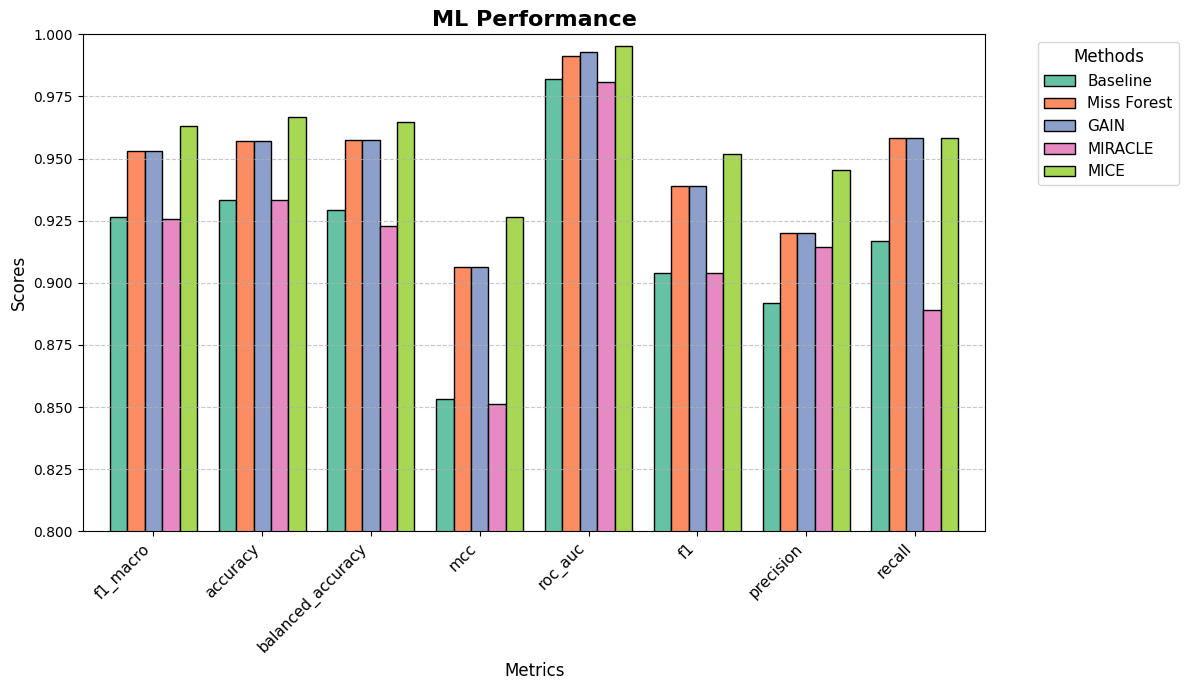

In [39]:
plot(result=res, title='ML Performance', y_limit=(0.8,1), log_scale=False)

In [19]:
cal_metrics(
    original=df_ori,
    imputed=pd.concat([train_imputed_mf, test_imputed_mf])
    .sort_index()
    .clip(lower=1, upper=10)
    .round(),
)

NameError: name 'cal_metrics' is not defined

In [93]:
cal_metrics(
    original=df_ori,
    imputed=pd.concat([train_imputed_gain, test_imputed_gain])
    .sort_index()
    .clip(lower=1, upper=10)
    .round(),
)

{'mae': 0.31961932650073205, 'rmse': 0.9522263347961742}

In [94]:
cal_metrics(
    original=df_ori,
    imputed=pd.concat([train_imputed_miracle, test_imputed_miracle])
    .sort_index()
    .clip(lower=1, upper=10)
    .round(),
)

{'mae': 0.590190336749634, 'rmse': 1.889982840951801}

In [100]:
cal_metrics(
    original=df_ori,
    imputed=pd.concat([train_imputed_mice, test_imputed_mice])
    .sort_index()
    .clip(lower=1, upper=10)
    .round(),
)

{'mae': 0.4292825768667643, 'rmse': 1.1909861558498744}

In [ ]:
cal_metrics(
    original=df_ori,
    imputed=pd.concat([train_imputed_miracle, test_imputed_miracle])
    .sort_index()
    .clip(lower=1, upper=10)
    .round(),
)

{'mae': 0.590190336749634, 'rmse': 1.889982840951801}